In [7]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt


In [4]:

def create_binary_mask(image_path, threshold=128):
    """
    Loads an image, converts it to grayscale, and creates a binary mask.

    For LIME, the effective threshold should be low (e.g., 1) to capture any non-black pixel.
    For Grad-CAM, a higher threshold is used to segment the heatmap.

    Args:
        image_path (str): The full path to the input image.
        threshold (int): The pixel value threshold for binarization.

    Returns:
        A binary mask (numpy array) or None if the image cannot be loaded.
    """
    try:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise FileNotFoundError(f"Image not found or could not be read at {image_path}")
        
        # Apply the binary threshold to create the mask
        _, binary_mask = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)
        return binary_mask
    except Exception as e:
        print(f"Error creating mask for {os.path.basename(image_path)}: {e}")
        return None

def calculate_iou(mask1, mask2):
    """
    Calculates the Intersection over Union (IoU) for two binary masks.

    Args:
        mask1 (numpy.ndarray): The first binary mask.
        mask2 (numpy.ndarray): The second binary mask.

    Returns:
        float: The IoU score between 0.0 and 1.0.
    """
    # Ensure masks are the same size, resizing the second mask if necessary
    if mask1.shape != mask2.shape:
        mask2 = cv2.resize(mask2, (mask1.shape[1], mask1.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Convert masks to boolean arrays for efficient logical operations
    mask1_bool = mask1.astype(bool)
    mask2_bool = mask2.astype(bool)

    # Calculate intersection and union
    intersection = np.logical_and(mask1_bool, mask2_bool)
    union = np.logical_or(mask1_bool, mask2_bool)

    # Compute the IoU score
    intersection_area = np.sum(intersection)
    union_area = np.sum(union)
    
    if union_area == 0:
        return 1.0 if intersection_area == 0 else 0.0 # Both masks are empty

    return intersection_area / union_area


Starting IoU Comparison...
--------------------------------------------------


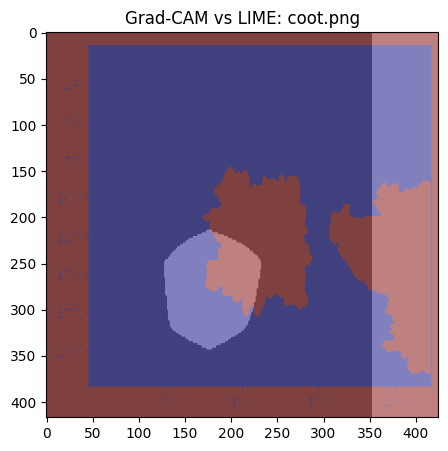

Image: coot.png                  | IoU Score: 0.1258


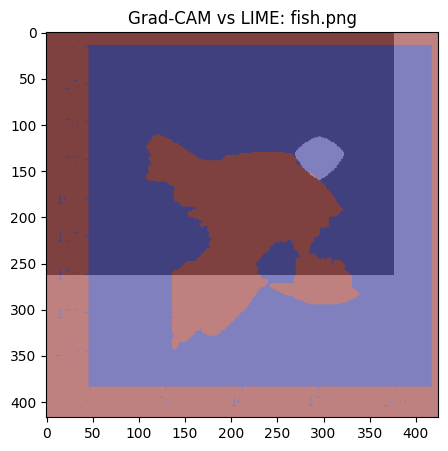

Image: fish.png                  | IoU Score: 0.0014


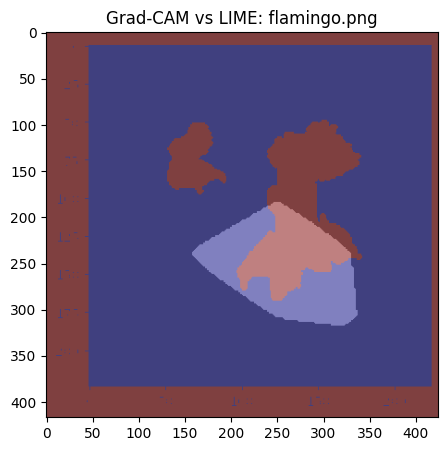

Image: flamingo.png              | IoU Score: 0.0673


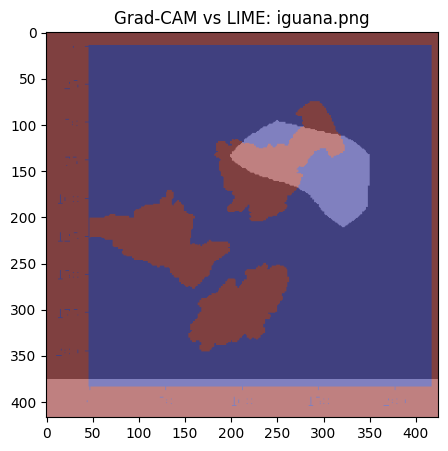

Image: iguana.png                | IoU Score: 0.0832


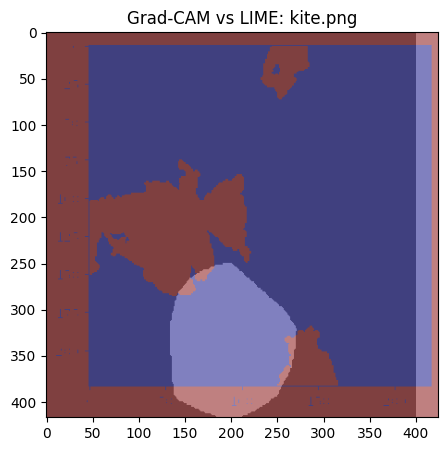

Image: kite.png                  | IoU Score: 0.0354


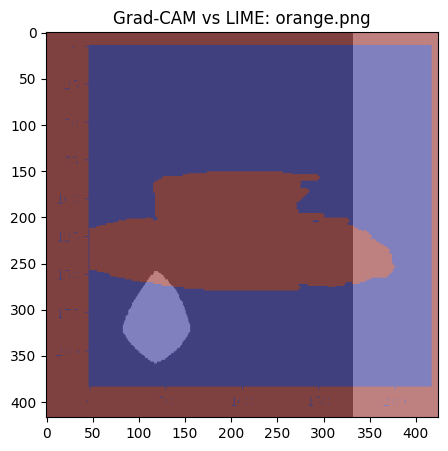

Image: orange.png                | IoU Score: 0.0548


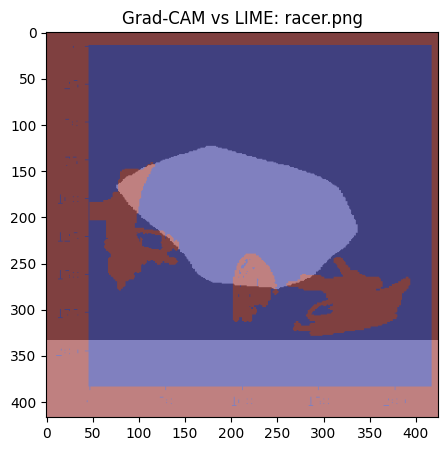

Image: racer.png                 | IoU Score: 0.0720


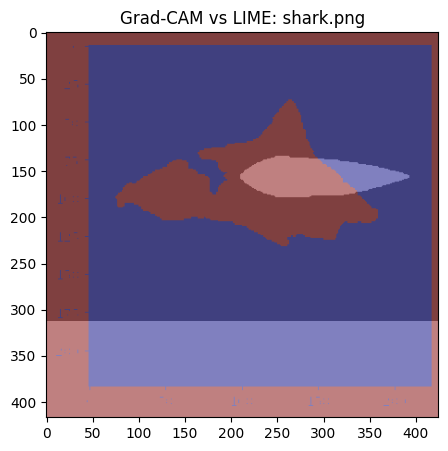

Image: shark.png                 | IoU Score: 0.0728


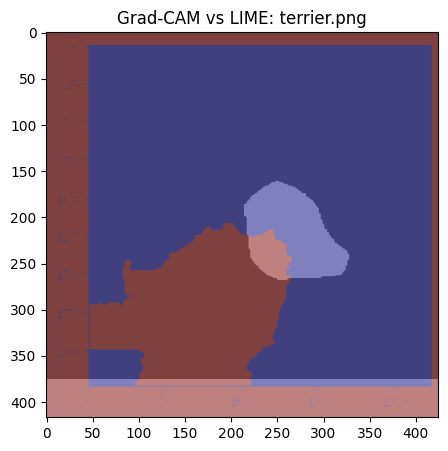

Image: terrier.png               | IoU Score: 0.0822


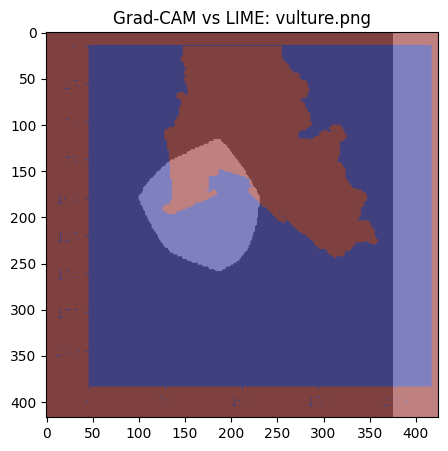

Image: vulture.png               | IoU Score: 0.1073
--------------------------------------------------
Average IoU for 10 images: 0.0702


In [ ]:
def main():
    """
    Main function to compare explanation masks from two directories.
    """
    gradcam_dir = '../notebooks/output_gradcam_mask/'
    lime_dir = '../task3/explanation'
    iou_scores = []

    if not os.path.isdir(gradcam_dir):
        print(f"Error: Directory not found: {gradcam_dir}")
        return
    if not os.path.isdir(lime_dir):
        print(f"Error: Directory not found: {lime_dir}")
        return

    lime_files = sorted([f for f in os.listdir(lime_dir) if os.path.isfile(os.path.join(lime_dir, f))])
    gracam_files = sorted([f for f in os.listdir(gradcam_dir) if os.path.isfile(os.path.join(gradcam_dir, f))])

    if not lime_files:
        print(f"No files found in {lime_dir}.")
        return

    print("Starting IoU Comparison...")
    print("-" * 50)
    
    overlaps_images = []

    for filename in lime_files:
        
        lime_path = os.path.join(lime_dir, filename)
        label_name = filename.split(".")[0]
        # Get the corresponding Grad-CAM file name by filtering the filename containg the same base name
        filter(lambda f: label_name in f, gracam_files)
        gradcam_file = next((f for f in gracam_files if label_name in f)
                            , None)
        if not gradcam_file:
            print(f"Skipping {filename}: No corresponding Grad-CAM file found.")
            continue


        gradcam_path = os.path.join(gradcam_dir, gradcam_file)

        # Create binary masks for both images
        # For Grad-CAM, a threshold of 128 is a good starting point
        gradcam_mask = create_binary_mask(gradcam_path, threshold=128)
        
        # For LIME, a very low threshold ensures all explanation segments are captured
        lime_mask = create_binary_mask(lime_path, threshold=1)

        fig = plt.figure(figsize=(10, 5))
        # Show both masks
        plt.imshow(gradcam_mask, cmap='gray', alpha=0.5)
        plt.imshow(lime_mask, cmap='jet', alpha=0.5)
        plt.title(f'Grad-CAM vs LIME: {filename}')
        plt.show()

        if gradcam_mask is None or lime_mask is None:
            continue

        # Calculate and store the IoU score
        iou_score = calculate_iou(gradcam_mask, lime_mask)
        iou_scores.append(iou_score)
        
        print(f"Image: {filename:<25} | IoU Score: {iou_score:.4f}")

    # --- Final Report ---
    if iou_scores:
        average_iou = sum(iou_scores) / len(iou_scores)
        print("-" * 50)
        print(f"Average IoU for {len(iou_scores)} images: {average_iou:.4f}")
    else:
        print("Could not compute IoU for any image pairs.")

if __name__ == '__main__':
    main()